<a href="https://colab.research.google.com/github/MonicaKim89/Arthritis_Classification/blob/main/%5B0315%5D_VGG_RF_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%cd /content/drive/MyDrive/py_storage

/content/drive/MyDrive/py_storage


In [47]:
!pip install keras.utils

In [48]:
!pip install to_categorical

ERROR: Could not find a version that satisfies the requirement to_categorical (from versions: none)
ERROR: No matching distribution found for to_categorical


In [49]:
!pip install split_folders

In [50]:
from tensorflow.keras.utils import to_categorical
from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1010248165192194226
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14500545085787612071
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]
tf 2.8.0
keras 2.8.0
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라


In [51]:
set_global_determinism(seed=1337)

In [52]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

file_list = os.listdir("/content/drive/MyDrive/Projects/knee/VIT_DATA/for_vit/train")
# file_list = file_list[1:]
print(file_list)

['0', '1', '2', '3', '4']


In [53]:
data_path = "/content/drive/MyDrive/Projects/knee/VIT_DATA/for_vit/"
a = get_file_list(data_path)
a

['/content/drive/MyDrive/Projects/knee/VIT_DATA/for_vit/test',
 '/content/drive/MyDrive/Projects/knee/VIT_DATA/for_vit/train']

In [54]:
from sklearn.preprocessing import label_binarize
categories = ['0', '1', '2', '3','4']

In [55]:
from tqdm import tqdm

In [56]:
SIZE = 224  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in tqdm (glob.glob(data_path+'train/*')):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(len(train_images))

100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

4455


In [57]:
SIZE = 224  #Resize images

#Capture training data and labels into respective lists
test_images = []
test_labels = [] 

for directory_path in tqdm (glob.glob(data_path+'test/*')):
    label = directory_path.split("/")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

#Convert lists to arrays        
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(len(test_images))
print(len(test_labels))

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

1114
1114


In [58]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#딥러닝으로 들어갈때는 원핫으로 들어가야함

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [59]:

from keras.applications.vgg16 import VGG16

In [60]:
#Load model wothout classifier/fully connected layers
SIZE = 224
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train = features #This is our X input to RF

In [62]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_train, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
# print(prediction_RF)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
# print(prediction_RF)

In [63]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.4757630161579892


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


              precision    recall  f1-score   support

           0       0.51      0.87      0.64       441
           1       0.29      0.04      0.07       204
           2       0.40      0.40      0.40       294
           3       0.55      0.12      0.20       144
           4       0.00      0.00      0.00        31

    accuracy                           0.48      1114
   macro avg       0.35      0.29      0.26      1114
weighted avg       0.43      0.48      0.40      1114



findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


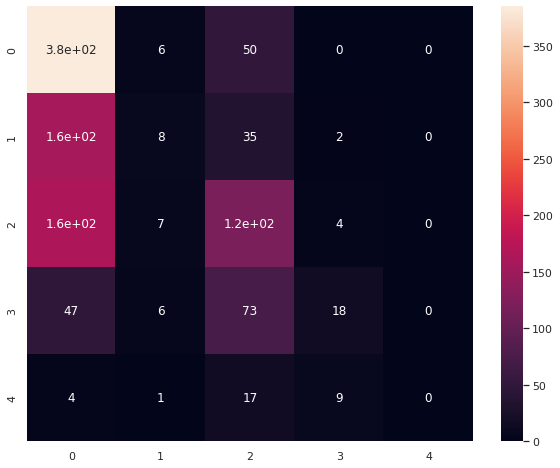

In [64]:
from sklearn.metrics import confusion_matrix
report = classification_report(test_labels, prediction_RF)
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
print(report)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['0']
The actual label for this image is:  0


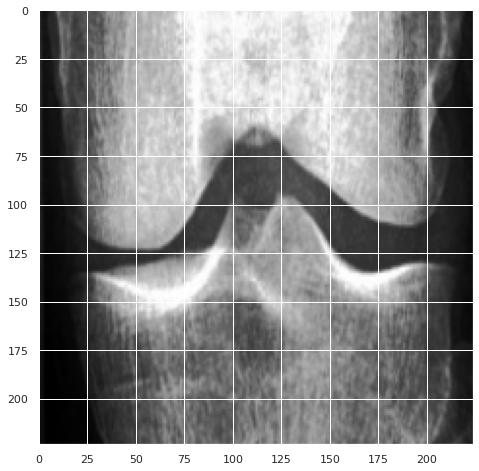

In [69]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

In [101]:
#evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [102]:
y_score = RF_model.fit(X_train, y_train).predict_proba(X_test_features)
y_score

array([[0.28, 0.14, 0.28, 0.24, 0.06],
       [0.52, 0.12, 0.28, 0.06, 0.02],
       [0.28, 0.1 , 0.36, 0.22, 0.04],
       ...,
       [0.24, 0.12, 0.2 , 0.3 , 0.14],
       [0.12, 0.08, 0.44, 0.3 , 0.06],
       [0.16, 0.04, 0.42, 0.28, 0.1 ]])

In [103]:
y = label_binarize(test_labels_encoded, classes=[0, 1, 2, 3, 4])
y[0]

array([1, 0, 0, 0, 0])

In [106]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [107]:
fpr

{0: array([0.        , 0.        , 0.        , 0.00148588, 0.00297177,
        0.00742942, 0.01634473, 0.02228826, 0.03120357, 0.04309064,
        0.05497771, 0.06686478, 0.08172363, 0.11292719, 0.13670134,
        0.16641902, 0.19465082, 0.22585438, 0.27934621, 0.33283804,
        0.38187221, 0.43387816, 0.49628529, 0.54829123, 0.60624071,
        0.653789  , 0.72213967, 0.78157504, 0.83060921, 0.8692422 ,
        0.90193165, 0.93759287, 0.9628529 , 0.98662704, 0.99405646,
        0.99702823, 1.        ]),
 1: array([0.        , 0.0032967 , 0.00549451, 0.01428571, 0.02307692,
        0.04725275, 0.06703297, 0.0978022 , 0.16043956, 0.25054945,
        0.36153846, 0.49340659, 0.61318681, 0.73846154, 0.84725275,
        0.90659341, 0.95164835, 0.97582418, 0.9956044 , 1.        ,
        1.        ]),
 2: array([0.        , 0.00121951, 0.00365854, 0.00487805, 0.00609756,
        0.00853659, 0.01829268, 0.02439024, 0.04146341, 0.06219512,
        0.09634146, 0.1402439 , 0.19878049, 0.27195

In [108]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [109]:
from itertools import cycle

In [110]:
n_classes = 5

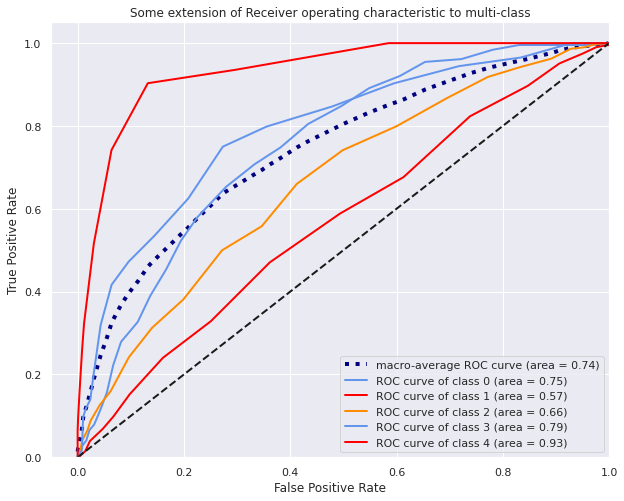

In [111]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'red', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [85]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_one_hot[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_one_hot[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_one_hot.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_one_hot, y_score, average="micro")

In [87]:
from sklearn.metrics import PrecisionRecallDisplay

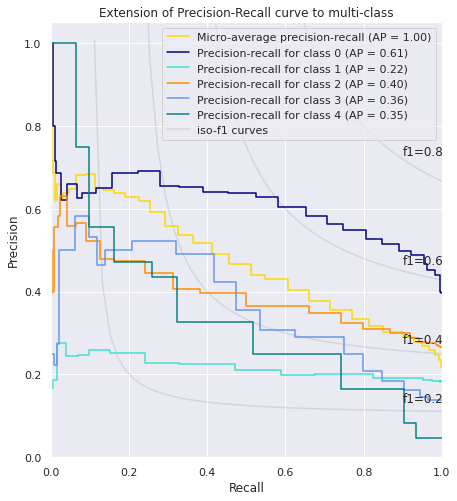

In [88]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=0.9969583665476998,
    estimator_name ='RF'
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
        estimator_name ='rf'
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()